# Deformando um nanotubo de carbono

* PET - Física UFRN
* Petiano: José Arthur de Luna Oliveira
* Data: 06 de Outubro de 2023

$\quad$ Neste `Notebook` vamos abordar um exemplo da Dinâmica Molecular(MD), a simulação da quebra de um nanotubo de carbono (CNT). O objetivo principal aqui é mostrar a utilização do programa `LAMMPS` em python tratando esse exemplo. Vale ressaltar que este trabalho foi bastante baseado no [tutorial do LAMMPS](https://lammpstutorials.github.io/sphinx/build/html/tutorials/level1/breaking-a-carbon-nanotube.html) **[1]**.

**OBS:** Caro leitor, caso queira se aprofundar mais sobre os comandos do LAMMPS utilizados neste `Notebook` aconselho ler sobre eles na Referência **[3]**.

Este `Notebook` possui 3 seções:

* Deformando CNT com ligações inquebráveis;
* Deformando CNT com ligações quebráveis;
* COnclusão.

## Pré-requisitos

$\quad$ Para que o usuário acompanhe códigos feitos neste `Notebook` é necessário ter o `LAMMPS` e o `VMD` instalado no computador, logo abaixo estão listados os links para fazer o download dos programas:

* [LAMMPS](https://docs.lammps.org/Install.html);

* [VMD](https://www.ks.uiuc.edu/Development/Download/download.cgi?PackageName=VMD).

## Importando bibliotecas

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Detalhes das bibliotecas

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy

Software versions
Python 3.11.4 64bit [MSC v.1916 64 bit (AMD64)]
IPython 8.12.0
OS Windows 10 10.0.22621 SP0
Matplotlib 3.7.1
Numpy 1.24.3
Sat Oct 28 14:31:08 2023 Hora Padrão de Buenos Aires

## 1. Deformando um nanotubo com ligações inquebráveis

### 1.1 Gerando a estrutura

$\quad$ Antes de tudo, devemos gerar a configuração inicial do sistema no `VMD`, para isso abra o programa e siga o pequeno tutorial abaixo.

$\quad$ Com o programa ligado vá no terminal do `VMD` e localize a pasta que você utilizará com os comando do prompt de comando, quando tiver acesso a pasta ponha as seguintes linhas de comando a seguir, uma de cada vez, no terminal: `molinfo top set a 80`, `molinfo top set b 80`, `molinfo top set c 80` e `topo writelammpsdata cnt_molecular.data molecular`. Feito isso, um novo arquivo `.data` será criado com as informações de cada átomo do tubo de carbono. Caso queira visualiza-lo, a estrutura formada será igual a estrutura da figura abaixo.

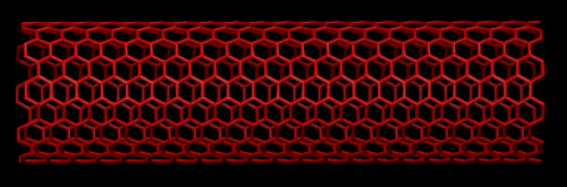

### 1.2 Criando o Input

$\quad$ Depois de gerada o CNT, agora vamos criar o input que é um arquivo feito com os códigos LAMMPS. Nesse arquivo deve conter todos os comando para rodar a simulção. Nesta seção, será exposto tudo o que será necessário para criar esse arquivo. Começaremos com os comandos de incialização do sistema.

In [3]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Inicialização

#variable T equal 300

#units real
#atom_style molecular
#boundary f f f 
#pair_style lj/cut 14

#bond_style harmonic
#angle_style harmonic
#dihedral_style opls
#improper_style harmonic

#special_bonds lj 0.0 0.0 0.5

#read_data cnt_molecular.data

A segui a funcionalidade de cada comando usado:

* `units`: determina as unidades utilizadas na simulação, nesse caso usamos *real*, de forma que as unidades de medidas das distâncias serão dadas em Angstroms e o tempo em femtossegundo ($10^{-15} \ s$);

* `atom_style`: define o tipo de átomos que será utilizado na simulação;

* `boundary`: configura as paredes da caixa (região, onde a simulação ocorre), as condições de contorno, cujo escolhemos paredes não periódicas (*f*);

* `pair_style`: define a fórmula que o LAMMPS usará para calcular a interação entre os átomos, aqui usaremos o potencial de Lennard Jones (LJ) (caso leitor queira ter um entendimento melhor sobre esse potencial, aconselho a leitura do notebook *nvestigação da energia de ligação entre átomos utilizando o potencial de Lennard-Jones.*, **[2]**), o parâmetro 14, que definimos, significa que o átomos a uma distância menor que $14$ Angstrom entre si terão uma interação através do potencial LJ;

* `bond_style`, `angle_style`, `dihedral_style` e `improper_style` definem diferentes potenciais utilizados para restringir a posição do átomos.

$\quad$ Note que não trabalharemos com a interação coulombiana, pois em um tubo de carbono não há cargas parciais. Cargas parciais surge quando uma molécula é formada por átomos de eletronegatividade diferentes, que conseguinte causa uma distribuição desigual de cargas entre eles, no qual o átomo com a maior concetração de carga negativa possuirá uma carga parcial negativa ($\delta^-$) e assim a outra terá uma carga parcial positiva ($\delta^+$), criando um momento de dipolo.

$\quad$ Agora, vamos especificar os parâmetros de ambas as funções de ligações e não ligações. Para isso, devemos criar um novo arquivo de texto na mesma pasta, chamaremos de "parm.in".

In [4]:
%%writefile parm.in

# Parametros
pair_coeff 1 1 0.066047 3.4
bond_coeff 1 469 1.4
angle_coeff 1 63 120
dihedral_coeff 1 0 7.25 0 0
improper_coeff 1 5 180

Writing parm.in


A segui as funções dos comando:

* `pair-coeff`: configura os parâmetro $\epsilon$ e $\sigma$ do potencial LJ, para o carbono devemos usar o número $1$;

* `bond_coeff`: provê a distância de equilíbrio $r_0$ e a constante $K_r$ para o potencial harmônico, imposto entre os dois átomos de carbono vizinhos, cujo potencial é $E = K_r(r - r_0)^2$;

* `angle_coeff`: nos dá o ângulo de equilíbrio e a constante para o potencial para três átomos vizinhos, definido como $E = K_{\theta}(\theta - \theta_0)^2$;

* `dihedral_coeff` e `improper_coeff` fornecem o potencial para restringir as interações entre quatro átomos. 

Este arquivo deve ser lido pelo nosso `input`.

In [5]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Parâmetros da simulação

#include in.parm.lmp

$\quad$ Para termos certeza que o CNT esteja centralizado, isto dependará da versão do VMD que está sendo usada, vamos fazer uma translação no sistema de coordenadas, de modo que o CNT fique na origem do sistema e também recentralizaremos a caixa na origem do sistema, pois a mesma não é centralizada.

**Centralizando o CNT:**

In [6]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Recentralizando o CNT

#group carbon_atoms type 1
#variable carbon_xcm equal -1*xcm(carbon_atoms,x)
#variable carbon_ycm equal -1*xcm(carbon_atoms,y)
#variable carbon_zcm equal -1*xcm(carbon_atoms,z)
#displace_atoms carbon_atoms move ${carbon_xcm} ${carbon_ycm} ${carbon_zcm}

A seguir a funcionalidade de cada comando:

* `group`: usamos ele para incluir todos os átomos em um grupo chamado *carbon_atoms*;
* As três variáveis *carbon_xcm*, *carbon_ycm* e *carbon_zcm* serve para medir a posição do grupo que criamos nas direções x, y e z, respectivamente;
* `displace_atoms`: moverá o grupo *carbon_atoms*, garantindo que seu centro de massa esteja na origem do sistema de coordenadas.

**Centralizando a caixa:**

In [7]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Recentralizando a caixa

#change_box all x final -40 40 y final -40 40 z final -40 40

$\quad$ Para podermos deformar o CNT iremos aplicar forças opostas em cada ponta do tubo, portanto devemos separar os átomos de cada ponta em grupos diferentes. Posteriormente, o deslocamento será aplicado aos átomos das arestas da caixa. 

In [8]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

#variable zmax equal bound(carbon_atoms,zmax)-0.5
#variable zmin equal bound(carbon_atoms,zmin)+0.5
#region rtop block INF INF INF INF ${zmax} INF
#region rbot block INF INF INF INF INF ${zmin}
#region rmid block INF INF INF INF ${zmin} ${zmax}

A seguir a funcionalidade de cada comando:

* $z_{max}$ é a variável que corresponde as coordenadas dos átomos que estão na posição L/2 menos 0.5 Angstroms, em que L é o comprimento total do cubo;
* $z_{min}$ é a variável para coordenadas dos dos átomos que estão na posição L/2 mais $0.5$ Angstroms;
* `region`: usamos para definir três regiões que correspondem respectivamente à $z < z_{min}$ (*rbot*), $z_{min} < z < z_{max}$ (*rmid*) e $z > z_{max}$ (*rtop*).

Em seguida, definiremos os três grupos de átomos correspondentes aos átomos localizados em cada uma das três regiões.

In [9]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

#group carbon_top region rtop
#group carbon_bot region rbot
#group carbon_mid region rmid

A seguir, configuraremos a termalização e a dinêmica do sistema.

In [10]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Termalização e dinâmica do sistema

#velocity carbon_mid create ${T} 48455 mom yes rot yes
#fix mynve all nve
#compute Tmid carbon_mid temp
#fix myber carbon_mid temp/berendsen ${T} ${T} 100
#fix_modify myber temp Tmid

Abaixo está a funcionalidade de cada comando:

* `velocity_create`: define as velocidades iniciais para o átomos do grupo *carbon_mid*, nos garantindo uma temperatura inicial de $300 \ K$ para esses átomos sem momento translacional e rotacional;
* `fix` *nve* é aplicado para todos os átomos, para que suas posições sejam recalculadas a cada intervalo de tempo;
* Aplicamos o termostato Berendsen (Rühle; Victor, 2007)**[4]** apenas nos átomos do grupo *carbon_mid*;
* `fix_modify myber`: é para garantir que o *fix Berendsen* use a temperatura do grupo *carbon_mid* como um input, em vez da temperatura do sistema, pois assim, os bordas congeladas não interferirá no sistema.

$\quad$ Note que os átomos da borda não precisam do termostato, porque seus movimentos serão restringidos. 

$\quad$ Como dito anteriormente vamos restringir o movimento dos átomos da bordas, para isso precisaremos dos comandos a seguir:

In [11]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Restrigindo o movimento dos átomos da borda

#fix mysf1 carbon_top setforce 0 0 0
#fix mysf2 carbon_bot setforce 0 0 0
#velocity carbon_top set 0 0 0
#velocity carbon_bot set 0 0 0

A seguir a funcionalidade de cada comando:

* `setforce` é um comando que cancela as forças aplicadas nos átomos das duas bordas, com o *fix setforce* garantimos aplicação disso a cada passo da simulação, que são aplicados ao longo das três direções;
* as duas linhas com o comando `velocity set` configura a velocidade inicial dos átomos das bordas igual a 0 para as três direções.

$\quad$ Dessa forma, os átomos nessas regiões irão ficar imóveis durante toda a simulação.

$\quad$ Agora, para medir a deformação e a tensão que o CNT sofrerá, devemos salvar em um arquivo as distâncias entres as pontas do tubo e também a força aplicada nelas.

In [12]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Salvando os dados

#variable L equal xcm(carbon_top,z)-xcm(carbon_bot,z)
#fix at2 all ave/time 10 100 1000 v_L file length.dat
#fix at3 all ave/time 10 100 1000 f_mysf1[3] f_mysf2[3] file force.dat

Abaixo a explicação do código feito:
* A varável *L* recebe o valor que é a distância entre os átomos nas regiões *carbon_top* e *carbon_bot*;
* A segunda linha cria um arquivo chamado *lengh.dat*, no qual terá duas colunas uma com as informações do tempo decorrido e a outra com os valores da variável *L* ao longo desse tempo;
* A terceira linha ele cria um arquivo chamado *force.dat*, em que há duas colunas cada uma possui os dados das forças dos grupos *carbon_top* e *carbon_bot*, respectivamente.

$\quad$ Agora vamos também adicionar o comando para salvarmos as coordenadas dos átomos em um arquivo *lammpstrj* a cada 1000 passos.

In [13]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Salvando as coordenadas

#dump mydmp all atom 1000 dump.lammpstrj

O comando `dump` cria um arquivo, cujo possui os dados das trajetórias dos carbonos durante toda a simulação.

$\quad$ Para fazer a simulação, o sistema tem que está em equilíbrio e para isso devemos deixar o sistema livre até que os átomos fiquem na posição de equilíbrio. Dessa forma, o input deve ser executado em um curto espaço de tempo para o sistema entrar em equilíbrio, então levar o sistema a uma temperatura necessária para aplicar qualquer deformação.

In [14]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Rodando

#thermo 100
#thermo_modify temp Tmid

#timestep 1.0
#run 5000

$\quad$ O comando `thermo_modify` diz ao LAMMPS que queremos que a temperatura $T_{mid}$ seja salva no terminal, em vez da temperatura do sistema.

$\quad$ A seguir vamos incrementar os comandos para gerar a deformação no CNT. Para garantir uma deformação suave e contínua, combinaremos os comandos `velocity set` e `fix setforce`.

In [15]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Deformando o CNT

#velocity carbon_top set NULL NULL 0.0005
#velocity carbon_bot set NULL NULL -0.0005
#run 10000

$\quad$ O código acima aplica para cada extremidade do CNT uma velocidade de 0.0005 Angstrom/femtosegundo, dessa forma a deformação que aplicaremos no final da simulação será de 0.0005x10000 = 5 Angstrom (dado que o comando `run` define o tempo total para deformar em femtosegundos).

In [16]:
%%writefile input.in

#Inicialização

variable T equal 300

units real
atom_style molecular
boundary f f f 
pair_style lj/cut 14

bond_style harmonic
angle_style harmonic
dihedral_style opls
improper_style harmonic

special_bonds lj 0.0 0.0 0.5

read_data cnt_molecular.data

#Parâmetros da simulação

include in.parm.lmp

#Recentralizando o CNT

group carbon_atoms type 1
variable carbon_xcm equal -1*xcm(carbon_atoms,x)
variable carbon_ycm equal -1*xcm(carbon_atoms,y)
variable carbon_zcm equal -1*xcm(carbon_atoms,z)
displace_atoms carbon_atoms move ${carbon_xcm} ${carbon_ycm} ${carbon_zcm}

#Recentralizando a caixa

change_box all x final -40 40 y final -40 40 z final -40 40

variable zmax equal bound(carbon_atoms,zmax)-0.5
variable zmin equal bound(carbon_atoms,zmin)+0.5
region rtop block INF INF INF INF ${zmax} INF
region rbot block INF INF INF INF INF ${zmin}
region rmid block INF INF INF INF ${zmin} ${zmax}

group carbon_top region rtop
group carbon_bot region rbot
group carbon_mid region rmid

#Termalização e dinâmica do sistema

velocity carbon_mid create ${T} 48455 mom yes rot yes
fix mynve all nve
compute Tmid carbon_mid temp
fix myber carbon_mid temp/berendsen ${T} ${T} 100
fix_modify myber temp Tmid

#Restrigindo o movimento dos átomos da borda

fix mysf1 carbon_top setforce 0 0 0
fix mysf2 carbon_bot setforce 0 0 0
velocity carbon_top set 0 0 0
velocity carbon_bot set 0 0 0

#Salvando os dados

variable L equal xcm(carbon_top,z)-xcm(carbon_bot,z)
fix at2 all ave/time 10 10 100 v_L file length.dat
fix at3 all ave/time 10 10 100 f_mysf1[3] f_mysf2[3] file force.dat

#Salvando as coordenadas

dump mydmp all atom 10 dump.lammpstrj

#Equilibrando

thermo 100
thermo_modify temp Tmid

timestep 1.0
run 5000

#Deformando o CNT

velocity carbon_top set NULL NULL 0.0005
velocity carbon_bot set NULL NULL -0.0005
run 10000

Writing input.in


### 1.3 Rodando o input

$\quad$ Antes de rodar a simulação vamos ver todos os arquivos da pasta *.in*, para isso vamos usar o comando do terminal do windows `dir`, vale a pena ressaltar que para excutar o arquivo input usaremos os comandos do terminal, ou seja, podemos fazer a simulação usando o terminal do computador, lembre que os comandos dos terminais mudam de acordo com o sistema operacional do computador.

In [17]:
!dir *in

 O volume na unidade C nÆo tem nome.
 O N£mero de S‚rie do Volume ‚ 0C73-3571

 Pasta de C:\Users\olive\PET.py\Notebook\Quebrando_um_nanotubo_de_carbono

27/10/2023  21:09             1.917 input.in
27/10/2023  21:09               142 parm.in
               2 arquivo(s)          2.059 bytes
               0 pasta(s)   120.338.587.648 bytes dispon¡veis


Agora para excutar o input no LAMMPS devemos chama-la usando o comando `lmp` (comando do LAMMPS), como foi feito abaixo:

In [18]:
#!lmp -in input.in

$\quad$ Quando começar rodar a simulação com célula de código acima o arquivo input será executado, após isso as seguintes linhas devem começar a aparecer:

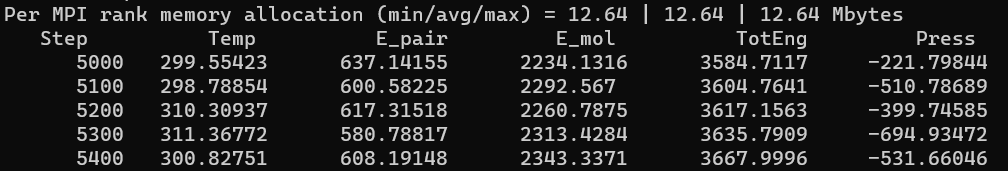

isso siginifica que a simulação está executando. Note que esta imagem foi retirada do terminal, mas no programa em python devem aparecer as mesmas linhas, no entanto só surgem depois que toda a simulação foi executada.

$\quad$ Assim com o arquivo *dump*, criado após a execução do input, podemos ver usando o `VMD` o CNT se alongando, como pode ser visto no [vídeo](https://www.youtube.com/watch?v=SBPLFuBCGRM), porém pelo campo de força que estamos impondo, não importa o quanto alonguemos o CNT ele não se romperá. Dessa forma, para podermos simular a quebra do nanotubo mudaremos o campo de força, faremos isso na próxima seção.

## 2. Deformando CNT com ligações quebráveis

Nesta seção, usaremos um campo de força reativo para vermos as ligações quebrarem.

### 2.1 Criando o input

$\quad$ Vamos utilizar a mesma estrutura CNT gerada na seção anterior, porém será necessário alterar algumas partes do arquivo mais adiante. Então, vamos começar a criar o input:

In [19]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Inicialização

#variable T equal 300

#units metal
#atom_style molecular
#boundary p p p 
#pair_style airebo 2 1 1

$\quad$ Note que diferente da Seção 1, aqui definimos como unidade do sistema o *metal* em vez de *real*, ainda sim possui como unidade de distância o Angstrom, mas a unidade de tempo é em picosegundos. Já o campo de força, impusemos o airebo (para saber mais desse potencial de uma olhada na Referêcnia [3]).

$\quad$ Vamos agora mexer no arquivo *cnt_molecular.data*, duplique o arquivo com o nome *cnt_atom.data* e remova toda a informação sobre *bond*, *angle* e *dihedral*, faça isso manualmente. Fazemos isso pela força reativa usada não precisar das informações de ligações, pois esse campo de força determina as ligações entre os átomos em tempo real com base nas posições dos átomos. Assim, quando a distância entre dois átomos inicialmente ligados se torna muito grande, a ligação pode quebrar.

In [20]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Parâmetros da simulação

#read_data cnt_atom.data
#pair_coeff * * CHrcc2.airebo C

$\quad$ O *CHrcc2.airebo* é um arquivo, cujo possui os parâmetros do potencial airebo para hidrocarboneto. Em seguida, dizemos ao LAMMPS que só há o átomos de carbonos no sistema, fizemos isso usando a letra C. O resto do código segue o mesmo padrão do input feito na seção anterior.

In [21]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Recentralizando o CNT e a caixa
#change_box all x final -40 40 y final -40 40 z final -60 60

#group carbon_atoms type 1
#variable carbon_xcm equal -1*xcm(carbon_atoms,x)
#variable carbon_ycm equal -1*xcm(carbon_atoms,y)
#variable carbon_zcm equal -1*xcm(carbon_atoms,z)
#displace_atoms carbon_atoms move ${carbon_xcm} ${carbon_ycm} ${carbon_zcm}

#variable zmax equal bound(carbon_atoms,zmax)-10
#variable zmin equal bound(carbon_atoms,zmin)+10
#region rtop block INF INF INF INF ${zmax} INF
#region rbot block INF INF INF INF INF ${zmin}
#region rmid block INF INF INF INF ${zmin} ${zmax}

#group carbon_top region rtop
#group carbon_bot region rbot
#group carbon_mid region rmid

##Termalização e dinâmica do sistema

#velocity carbon_mid create ${T} 48455 mom yes rot yes
#fix mynve all nve
#compute Tmid carbon_mid temp
#fix myber carbon_mid temp/berendsen ${T} ${T} 0.1
#fix_modify myber temp Tmid

$\quad$ Para deformar bastante o CNT, colocamos uma grande distância no eixo z, feito com o `change_box`. Este deve ser posto antes do comando do `displace_atoms` para evitar problemas do CNT cruzando a borda da caixa.

$\quad$ Para esticar o CNT imporemos uma velocidade constante para as duas pontas dos tubos, da mesma forma como fizemos na Secção anterior.

In [22]:
#Copie que está logo abaixo no arquivo input.in sem um "#"

##Restrigindo o movimento dos átomos da borda

#fix mysf1 carbon_bot setforce 0 0 0
#fix mysf2 carbon_top setforce 0 0 0
#velocity carbon_bot set 0 0 0
#velocity carbon_top set 0 0 0

##Salvando os dados

#variable pos equal v_zmax-v_zmin
#fix at1 all ave/time 10 10 100 v_pos file cnt_deflection.dat
#fix at2 all ave/time 10 10 100 f_mysf1[3] f_mysf2[3] file edge_force.dat

##Salvando as coordenadas

#dump mydmp all atom 1000 dump.lammpstrj

##Equilibrando

#thermo 100
#thermo_modify temp Tmid

#timestep 0.0005
#run 5000

##Deformando o CNT

#velocity carbon_top set 0 0 0.03
#velocity carbon_bot set 0 0 -0.03
#run 280000

### 2.2 Executando o input

$\quad$ Para executar o input usaremos o mesmo processo feito na Seção anterior.

In [23]:
%%writefile input2.in

#Inicialização

variable T equal 300

units metal
atom_style molecular
boundary p p p 
pair_style airebo 2 1 1

#Parâmetros da simulação

read_data cnt_atom.data
pair_coeff * * CHrcc2.airebo C

#Recentralizando o CNT e a caixa

change_box all x final -40 40 y final -40 40 z final -60 60

group carbon_atoms type 1
variable carbon_xcm equal -1*xcm(carbon_atoms,x)
variable carbon_ycm equal -1*xcm(carbon_atoms,y)
variable carbon_zcm equal -1*xcm(carbon_atoms,z)
displace_atoms carbon_atoms move ${carbon_xcm} ${carbon_ycm} ${carbon_zcm}

variable zmax equal bound(carbon_atoms,zmax)-10
variable zmin equal bound(carbon_atoms,zmin)+10
region rtop block INF INF INF INF ${zmax} INF
region rbot block INF INF INF INF INF ${zmin}
region rmid block INF INF INF INF ${zmin} ${zmax}

group carbon_top region rtop
group carbon_bot region rbot
group carbon_mid region rmid

#Termalização e dinâmica do sistema

velocity carbon_mid create ${T} 48455 mom yes rot yes
fix mynve all nve
compute Tmid carbon_mid temp
fix myber carbon_mid temp/berendsen ${T} ${T} 0.1
fix_modify myber temp Tmid

#Restrigindo o movimento dos átomos da borda

fix mysf1 carbon_bot setforce 0 0 0
fix mysf2 carbon_top setforce 0 0 0
velocity carbon_bot set 0 0 0
velocity carbon_top set 0 0 0

#Salvando os dados

variable pos equal v_zmax-v_zmin
fix at1 all ave/time 10 10 100 v_pos file cnt_deflection.dat
fix at2 all ave/time 10 10 100 f_mysf1[3] f_mysf2[3] file edge_force.dat

#Salvando as coordenadas

dump mydmp all atom 1000 dump.lammpstrj

#Equilibrando

thermo 100
thermo_modify temp Tmid

timestep 0.0005
run 5000

#Deformando o CNT

velocity carbon_top set 0 0 0.03
velocity carbon_bot set 0 0 -0.03
run 280000

Writing input2.in


In [24]:
!dir *in

 O volume na unidade C nÆo tem nome.
 O N£mero de S‚rie do Volume ‚ 0C73-3571

 Pasta de C:\Users\olive\PET.py\Notebook\Quebrando_um_nanotubo_de_carbono

27/10/2023  21:09             1.917 input.in
27/10/2023  21:09             1.772 input2.in
27/10/2023  21:09               142 parm.in
               3 arquivo(s)          3.831 bytes
               0 pasta(s)   120.338.583.552 bytes dispon¡veis


In [25]:
#!lmp -in input2.in

$\quad$ Da mesma maneira que o primeiro input, quando executado deve aparecer algo como o que está abaixo.

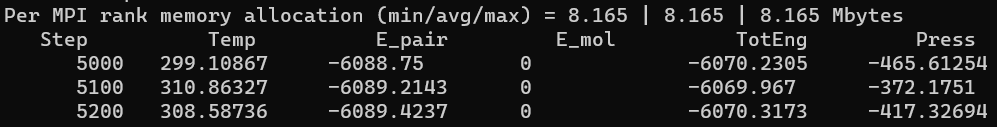

$\quad$ Dessa vez, com o campo de força reativo conseguimos ver as ligações do CNT quebrando com o stress que impomos, a simulação feita por este input deve ficar parecida com a desse [vídeo](https://youtu.be/7jFunRJrwT8).

## 2.3 Analisando o stress

$\quad$ Antes de tudo, vamor criar uma função para ornamentar o gráfico que será plotado.

In [26]:
def plot_ticks():
    plt.figure(figsize = (8,5))
    plt.minorticks_on()
    plt.tick_params(axis='x', which='both', top = True, right = True, direction = 'in', length=5, width=1)
    plt.tick_params(axis='y', which='both', top = True, right = True, direction = 'in', length=5, width=1)

### 2.3.1 Determinando o stress

$\quad$ Primeiro vamos medir o stress, para isso devemos dividir a força, que impomos para deformar o tubo, pela área da seção trnsversal. Para isso, pegaremos os dados do arquivo *edge_force*, na qual possui três colunas: a primeira refere-se ao tempo decorrido, a segunda coluna tem as informações da força aplicada no grupo de átomos *carbon_bot*, que definimos no input, já a terceira coluna possui os dados da força aplicada imposta ao grupo de átomos *carbon_top*.

Lembrando que força da arquivo está em eV/Angstrom, devido ao tipo de unidades que pomos com o comando `units`.

In [27]:
data_force = np.loadtxt("edge_force.dat", delimiter = " ") #extraindo os dados do arquivo
force_bot = np.array(data_force[:, 1]) #criando um array com a força imposta no no grupo carbon_bot
force_top = np.array(data_force[:, 2]) #criando um array com a força imposta no no grupo carbon_top

$\quad$ Devemos transformar as unidades das forças de eV/Angstrom para Newton, dado que 1 eV/Angstrom = $\small{1.602×10^{−9} \ N}$.

In [28]:
# mudando as unidades da força
force_bot = force_bot*1.602e-9
force_top = force_top*1.602e-9
force_bot, force_top

(array([1.94721498e-08, 1.43957322e-08, 1.26281174e-08, ...,
        3.92052654e-10, 4.88025270e-09, 4.41956556e-09]),
 array([-1.97118090e-08, -1.41321551e-08, -1.33404307e-08, ...,
        -4.05134586e-09, -6.57595368e-09, -6.42808908e-09]))

$\quad$ Agora vamos determinar a área do CNT, com a ajuda do `VMD` conseguimos ver que o diâmetro é de 13.56 Å, assim é fácil ver que a área transversal do nosso nanotubo é de $144.414 \ Å^2$ $\implies 1.444x10^{-18} \ m^2$. Com isso, agora podemos determinar o stress aplicado no CNT.

In [29]:
stress_bot = force_bot/(1.444e-18)
stress_top = force_top/(1.444e-18)
stress = (stress_bot - stress_top)*1e-9

### 2.3.2 Determinando o strain (deformação)

$\quad$ No input pedimos para que fosse criado o arquivo chamado *cnt_deflection.dat*, onde tem informação da deformação do tubo, em que a primeira coluna é o tempo decorrido e a segunda é posição.

In [30]:
data_pos = np.loadtxt("cnt_deflection.dat", delimiter = " ")
comp_tubo = np.array(data_pos[:, 1])

$\quad$ Note que no arquivo ele começa com um valor de 30.349 Å , mas para a termos a deformação do tubo devemos subtrair 30.349 Å de todos os dados desse arquivo, já que tal valor representa o comprimento inicial do tubo. Perceba que o comprimento incial nesse arquivo é menor do que o tamanho original do tubo, pois definimos as variáveis *zmax* e *zmin* na posição 15.174 Å  e -15.174 Å, repectivamente, logo todos os átomos que vem depois das posições *zmin* e *zmax* se movimentam juntos, então a posição varia de forma igual nessa região. Então, qualquer posição de átomo dessa região serve como referência para determinarmos a deformação do CNT.

$\quad$ Além disso, vamos por a deformação em percentual, mas para isso usaremos o tamanho original do tubo.

In [31]:
strain = (comp_tubo-30.349)*100/50.349

Text(0.5, 1.0, 'Gráfico Stress x Strain')

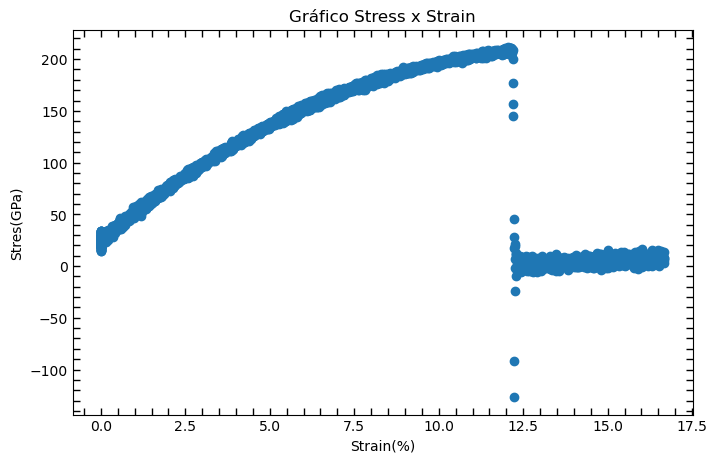

In [32]:
plot_ticks()
plt.plot(strain, stress, 'o')

plt.xlabel('Strain(%)')
plt.ylabel("Stres(GPa)")
plt.title("Gráfico Stress x Strain")

$\quad$ Com esse gráfico, é fácil ver que o nosso nanotubo de carbono rompe quando o stress está próximo dos 12%. Além disso, note que o stress não começa exatamente do zero, isso indica que o sistema não estava em equilibrio, em outras palavras o tempo que devemos deixar o sistema livre até encontrar o equilíbrio é maior do que o tempo que pomos.

## 3. Conclusão

$\quad$ Neste `Notebook` foi proposto um exemplo clássico da Dinâmica Molecular, expondo a simulação da deformação de um nanotubo de carbono e mostrada em uma abordagem em python. Tal método, é utilizado para fazer testes de tensão e torção em diversas estruturas, a fim de determinar as propriedades mecânicas e elásticas daquele material.

## Referências

**[1]** *Tutorial do LAMMPS*: https://lammpstutorials.github.io/index.html

**[2]** *Investigação da energia de ligação entre átomos utilizando o potencial de Lennard-Jones*: https://github.com/Josearthur266/PET.py/blob/main/Notebooks/Investigação%20da%20energia%20de%20ligação%20entre%20átomos%20utilizando%20o%20potencial%20de%20Lennard-Jones..ipynb

**[3]** *Commands LAMMPS*: https://docs.lammps.org/commands_list.html

**[4]** *Rühle, Victor. Berendsen and Nose-Hoover Thermostats. 2007.*

**[5]** *Dilrukshi, K.G.S., et al. “Size Dependency and Potential Field Influence on Deriving Mechanical Properties of Carbon Nanotubes Using Molecular Dynamics.” Theoretical and Applied Mechanics Letters, vol. 5, no. 4, July 2015, pp. 167–172, https://doi.org/10.1016/j.taml.2015.05.005. Accessed 25 Oct. 2023.*